In [1]:
import geopandas as gpd
from matplotlib import pyplot as plt
import numpy as np
from rasterio import Affine
from rasterio.features import rasterize
import xarray as xr

## Open the mosaics and the polygons

In [2]:
feature_cube = xr.open_dataset("/home/iborlafm/Downloads/Mozambique/hls/HLS_T36KXE_2018_b30_v2.0.nc")

In [3]:
slivers = gpd.read_file("/home/iborlafm/Downloads/Mozambique/hls/examplePolygons.gpkg")

## Prepare the crs and the affine from the mosaic

In [4]:
spatial_ref = feature_cube["spatial_ref"].attrs
crs = spatial_ref["crs_wkt"]
affine = Affine.from_gdal(*[float(f) for f in spatial_ref['GeoTransform'].split(" ")])

## Rasterize to array, convert to data array

In [5]:
# https://rasterio.readthedocs.io/en/stable/api/rasterio.features.html#rasterio.features.rasterize
rst = rasterize(
    shapes = slivers.to_crs(crs)[["geometry", "class_id"]].to_records(index=False).tolist(),
    out_shape=feature_cube["Red"].shape[1:],
    transform=affine
)

In [6]:
label_cube = xr.DataArray(rst, coords={"y": feature_cube.y, "x": feature_cube.x}, name="class_id")

## flatten the input features

In [7]:
feature_frame = feature_cube.drop_vars("spatial_ref").to_dataframe().dropna().unstack(level="quantile")

### Rename the columns to a single level

In [8]:
feature_frame.columns = [f"{c[0]}_P{np.round(100 * c[1], 0).astype(int):03}" for c in feature_frame.columns]

## Flatten the labels

In [9]:
label_frame = label_cube.to_dataframe()

## Drop rows with no label (class_id == 0), and join the features

In [10]:
train_frame = label_frame[label_frame["class_id"] != 0].join(feature_frame)

## Re-fold to xarray object

In [11]:
train_cube = train_frame.to_xarray()

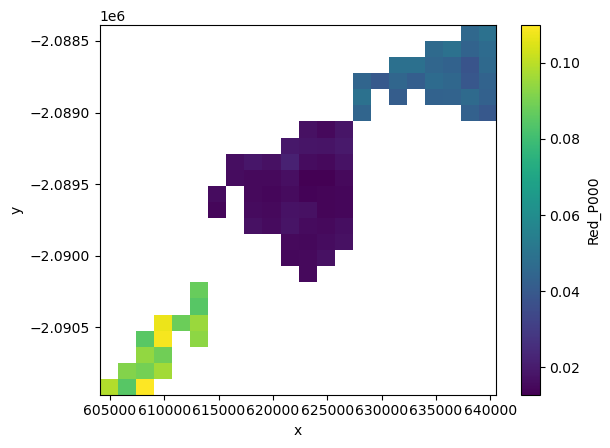

In [12]:
train_cube["Red_P000"].plot.imshow()